# DQN Project Part 3

Code runs through until completion

## Contributors: 
- Tadhg Ryan (21310408)
- Craig Phayer (21340633)
- Thomas McCarty (21327696)


In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs available:")
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("Name:", details.get('device_name', 'Unknown GPU'))
else:
    print("No GPU available.")

print(tf.__version__)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # set gpu 0 as default
# Suppressing TensorFlow's informational and warning logs to avoid output clutter.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only GPU 1
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPUs available:
Name: NVIDIA GeForce RTX 4060
2.10.0


In [2]:
# Importing libraries
import gymnasium as gym

# Creating the environment
env = gym.make("ALE/Qbert-v5", render_mode="rgb_array", frameskip=4)

# Inspecting the environment
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(6)
Observation space: Box(0, 255, (210, 160, 3), uint8)


In [3]:
import numpy as np
import cv2
from collections import deque

# Function to preprocess a single frame
def preprocess_frame(frame, augment=False):
    # Ensure the input is a NumPy array
    if isinstance(frame, tuple):
        frame = frame[0]  # Extract the observation if it's a tuple
    frame = np.array(frame)  # Ensure it's a NumPy array
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Resize to 84x84
    resized_frame = cv2.resize(gray_frame, (84, 84))

    # Normalize the frame to the range [0, 1]
    normalized_frame = resized_frame / 255.0

    if augment:
        # Random horizontal flip
        if np.random.random() > 0.5:
            normalized_frame = np.fliplr(normalized_frame)
        # Add random noise
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.01, normalized_frame.shape)
            normalized_frame = np.clip(normalized_frame + noise, 0, 1)
    return normalized_frame

# Initialize frame stack
frame_stack = deque(maxlen=4)

# Reset environment and initialize stack
def reset_env_with_stack(env):
    state, info = env.reset()
    processed_frame = preprocess_frame(state)
    for _ in range(4):  # Stack 4 identical frames initially
        frame_stack.append(processed_frame)
    return np.stack(frame_stack, axis=-1), info  # Shape: (84, 84, 4)

# Step the environment with frame stacking
def step_env_with_stack(env, action):
    next_state, reward, done, truncated, info = env.step(action)
    processed_frame = preprocess_frame(next_state)
    frame_stack.append(processed_frame)
    return np.stack(frame_stack, axis=-1), reward, done, truncated, info

state, _ = env.reset()
processed_frame = preprocess_frame(state, augment=True)
print("Processed frame shape:", processed_frame.shape)

Processed frame shape: (84, 84)


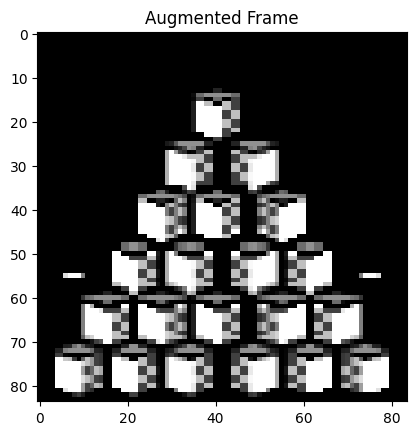

In [4]:
import matplotlib.pyplot as plt

state, _ = env.reset()
processed_frame = preprocess_frame(state, augment=True)
plt.imshow(processed_frame, cmap='gray')
plt.title("Augmented Frame")
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the DQN model
def create_dqn(action_space):
    model = models.Sequential([
        layers.Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=(84, 84, 4)),
        layers.Conv2D(64, (4, 4), strides=2, activation='relu'),
        layers.Conv2D(64, (3, 3), strides=1, activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(action_space, activation='linear')
    ])
    return model

# Initialize the model
dqn_model = create_dqn(env.action_space.n)
dqn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 1,687,206
Trainable params: 1,687,206
Non-

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def size(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(capacity=200000)

In [7]:
import random

def select_action(model, state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)  # Random action
    else:
        q_values = model.predict(state[None, ...])
        return np.argmax(q_values)

In [8]:
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

def record_gameplay(env, model, video_path="trained_agent_gameplay.mp4"):
    # Initialize video recorder
    recorder = VideoRecorder(env, video_path)

    # Initialize frame stack
    frame_stack = deque(maxlen=4)

    # Reset the environment
    state, info = env.reset()
    processed_frame = preprocess_frame(state)

    # Stack the same frame 4 times initially
    for _ in range(4):
        frame_stack.append(processed_frame)

    state = np.stack(frame_stack, axis=-1)  # Create the 4-channel input

    for _ in range(500):  # Limit steps in the episode
        # Predict action based on the current state
        action = np.argmax(model.predict(state[None, ...]))

        # Take a step in the environment
        next_state, reward, done, truncated, info = env.step(action)

        # Record the frame
        recorder.capture_frame()

        # Preprocess the next frame and update the stack
        processed_frame = preprocess_frame(next_state)
        frame_stack.append(processed_frame)
        state = np.stack(frame_stack, axis=-1)  # Update input state

        if done:
            break

    # Close the recorder and save the video
    recorder.close()
    recorder.enabled = False
    print(f"Gameplay recorded at recordings/{video_path}")


In [ ]:
def train_dqn(env, model, target_model, replay_buffer, episodes=500, batch_size=32, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, update_target=10, verbose=0):
    """
    Train the DQN model using Double DQN to reduce overestimation bias.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_fn = tf.keras.losses.Huber()
    rewards_history = []

    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0

        for step in range(10000):  # Limit steps per episode
            action = select_action(model, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, _ = step_env_with_stack(env, action)
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if replay_buffer.size() > batch_size:
                # Sample from the replay buffer
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size=batch_size)

                # Double DQN: Use the model to select actions, but the target model to evaluate Q-values
                next_q_actions = np.argmax(model.predict(next_states,verbose=verbose), axis=1)
                next_q_values = target_model.predict(next_states, verbose=verbose)
                target_q_values = rewards + gamma * next_q_values[np.arange(batch_size), next_q_actions] * (1 - dones)

                with tf.GradientTape() as tape:
                    q_values = model(states)
                    q_values = tf.reduce_sum(q_values * tf.one_hot(actions, env.action_space.n), axis=1)
                    loss = loss_fn(target_q_values, q_values)

                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if episode % update_target == 0:
            target_model.set_weights(model.get_weights())

        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return rewards_history

target_model = create_dqn(env.action_space.n)
target_model.set_weights(dqn_model.get_weights())  # Synchronize weights

rewards_history = train_dqn(
    env=env,
    model=dqn_model,
    target_model=target_model,
    replay_buffer=replay_buffer,
    episodes=100,  # Adjust for quick testing
    batch_size=64,
    gamma=0.99,
    epsilon=1.5,
    epsilon_min=0.1,
    epsilon_decay=0.998,
    update_target=20
)
print("Training complete!")

record_gameplay(env, dqn_model, video_path="trained_agent_gameplay.mp4")

Episode 1/100, Reward: 125.0, Epsilon: 1.497
Episode 2/100, Reward: 175.0, Epsilon: 1.494
Episode 3/100, Reward: 150.0, Epsilon: 1.491
Episode 4/100, Reward: 125.0, Epsilon: 1.488
Episode 5/100, Reward: 250.0, Epsilon: 1.485
Episode 6/100, Reward: 350.0, Epsilon: 1.482
Episode 7/100, Reward: 150.0, Epsilon: 1.479
Episode 8/100, Reward: 75.0, Epsilon: 1.476
Episode 9/100, Reward: 400.0, Epsilon: 1.473
Episode 10/100, Reward: 175.0, Epsilon: 1.470
Episode 11/100, Reward: 150.0, Epsilon: 1.467
Episode 12/100, Reward: 225.0, Epsilon: 1.464
Episode 13/100, Reward: 250.0, Epsilon: 1.461
Episode 14/100, Reward: 200.0, Epsilon: 1.459
Episode 15/100, Reward: 100.0, Epsilon: 1.456
Episode 16/100, Reward: 150.0, Epsilon: 1.453
Episode 17/100, Reward: 475.0, Epsilon: 1.450
Episode 18/100, Reward: 175.0, Epsilon: 1.447
Episode 19/100, Reward: 75.0, Epsilon: 1.444
Episode 20/100, Reward: 225.0, Epsilon: 1.441
Episode 21/100, Reward: 125.0, Epsilon: 1.438
Episode 22/100, Reward: 200.0, Epsilon: 1.435

In [ ]:
# Save the model's weights
dqn_model.save_weights("models/dqn_model_weights.h5")
print("Model weights saved!")

In [12]:
# Save the entire model
dqn_model.save("models/dqn_model.h5")
print("Model saved!")

Model saved!


In [13]:
def evaluate_agent(env, model, episodes=10):
    total_rewards = []
    for episode in range(episodes):
        state, _ = reset_env_with_stack(env)
        total_reward = 0
        done = False

        while not done:
            action = np.argmax(model.predict(state[None, ...]))
            next_state, reward, done, truncated, _ = step_env_with_stack(env, action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward}")

    print(f"Average Reward: {np.mean(total_rewards)}")

evaluate_agent(env, dqn_model, episodes=3)

1/1 [==============================] - 0s 30ms/step
Episode 1, Reward: 200.0
1/1 [==============================] - 0s 27ms/step
Episode 2, Reward: 400.0
1/1 [==============================] - 0s 29ms/step


C:\Users\craig\anaconda3\envs\tf_gpu\lib\site-packages\gymnasium\wrappers\monitoring\video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


1/1 [==============================] - 0s 35ms/step
Episode 3, Reward: 325.0
Average Reward: 308.3333333333333


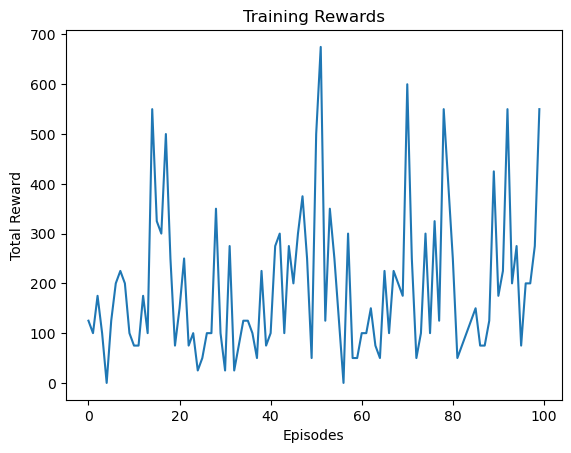

In [14]:
import matplotlib.pyplot as plt

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Rewards')
    plt.show()

# Example
plot_rewards(rewards_history)


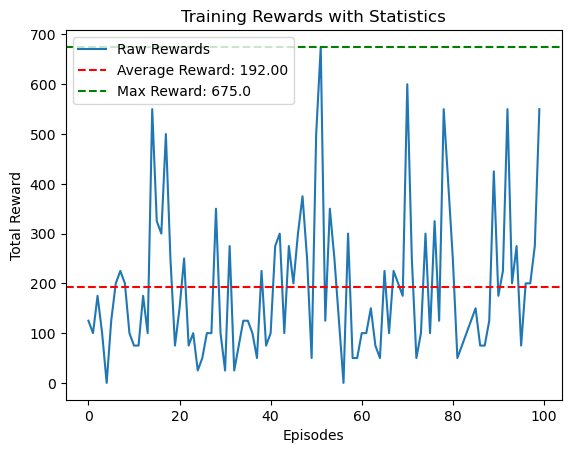

In [15]:
# Calculate key statistics
average_reward = np.mean(rewards_history)
max_reward = np.max(rewards_history)

# Plot the rewards with highlights
plt.plot(rewards_history, label="Raw Rewards")
plt.axhline(average_reward, color='r', linestyle='--', label=f"Average Reward: {average_reward:.2f}")
plt.axhline(max_reward, color='g', linestyle='--', label=f"Max Reward: {max_reward}")
plt.title("Training Rewards with Statistics")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


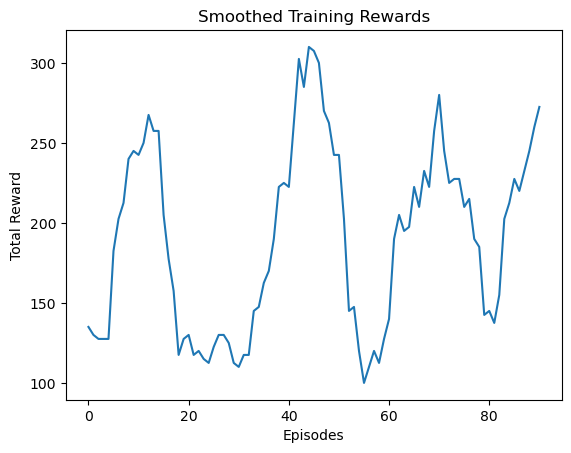

In [16]:
window = 10  # Adjust the window size as needed
smoothed_rewards = np.convolve(rewards_history, np.ones(window)/window, mode='valid')

# Plot smoothed rewards
plt.plot(smoothed_rewards)
plt.title("Smoothed Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

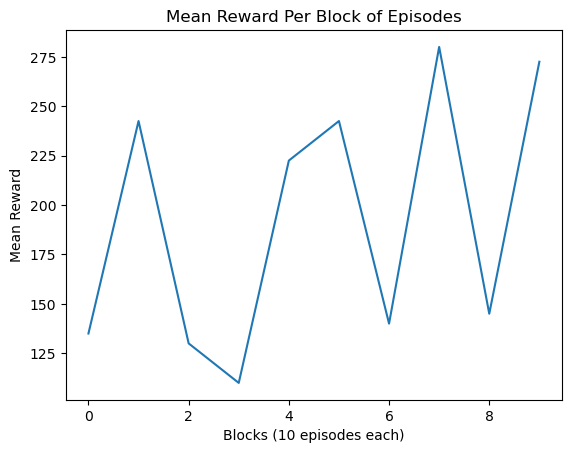

In [18]:
# Segment rewards into blocks
block_size = 10
block_means = [np.mean(rewards_history[i:i+block_size]) for i in range(0, len(rewards_history), block_size)]

# Plot block means
plt.plot(block_means)
plt.title("Mean Reward Per Block of Episodes")
plt.xlabel("Blocks (10 episodes each)")
plt.ylabel("Mean Reward")
plt.show()


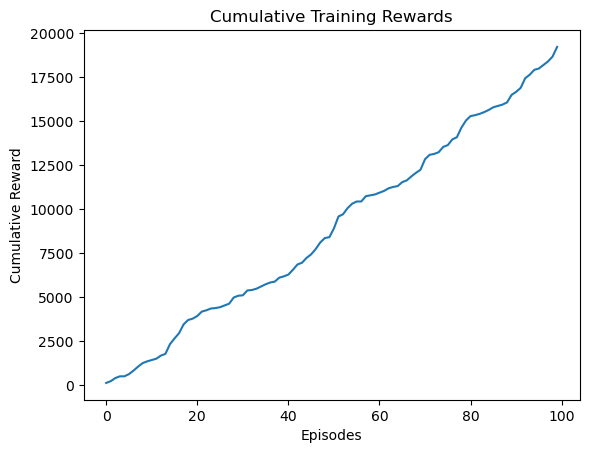

In [17]:
# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards_history)

# Plot cumulative rewards
plt.plot(cumulative_rewards)
plt.title("Cumulative Training Rewards")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
